# Introduction
Hi visitor,
this is my first NLP project and my first competition on Kaggle. I am familliar with the theoretical basics of NLP but never did a project on this topics especially with some pretrained models. So this is it. 

In this project I tried two approaches of pre-trained model us. One where I load the pre-trained model manually in the embeddings layer and use that layer as a part of my model (glove) and the other one based on Huggingfaces🤗 framework, where I use the from_pretrained() function which loads the whole model (with all layers).

INFO: According to the Kaggle dataset situation, I could find the Deberta base model there for Tensorflow therefore I needed to choose the roBerta model. So it could therefore occur the situation you find some variable / model / checkpoint names that are still named after deberta and not roberta. I will try to fix this one after the other.
And according to the current state of competition I focused on the Deberta/Roberta approach only which made my comment out the Glove model section. I will reactivate it in the final version of this notebook.

I thereforce ask you to bear with 🤗

# Imports and Datasets

In [1]:
import sys
assert sys.version_info >= (3,5)
import os
import pathlib

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder

import nltk
from string import punctuation
from collections import Counter

from scipy.spatial.distance import cosine

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Embedding, LSTM, Dense, Dropout, CuDNNLSTM, Bidirectional
from keras.layers.merge import concatenate
from transformers import BertTokenizer, TFDebertaModel

#import mlflow
#from mlflow import log_metric, log_param, log_artifacts
#import mlflow.tensorflow
#from mlflow import pyfunc

assert tf.__version__ >= "2.0"

print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
else:
    print(f'---Tensorflow is running with GPU Power now---')
    sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
    


random_state=42
tf.random.set_seed(random_state)
np.random.seed(random_state)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
#kaggle = 0 # Kaggle path active = 1

MAIN_PATH = os.getcwd()

# change your local path here
if iskaggle:
    DATA_PATH = os.path.join(MAIN_PATH, '../input')
    PHRASES_PATH = os.path.join(DATA_PATH, 'us-patent-phrase-to-phrase-matching')
else:
    DATA_PATH = os.path.join(MAIN_PATH, 'data')
    PHRASES_PATH = os.path.join(DATA_PATH,'input\\us-patent-phrase-to-phrase-matching')



for dirname, _, filenames in os.walk(PHRASES_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

d:\anaconda3\envs\wingpuflake_keras_GPU\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensorflow Version: 2.8.0
Keras Version: 2.8.0
---Tensorflow is running with GPU Power now---
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:04:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5

f:\python-workspace\phrase2phrase-match-ai\data\input\us-patent-phrase-to-phrase-matching\sample_submission.csv
f:\python-workspace\phrase2phrase-match-ai\data\input\us-patent-phrase-to-phrase-matching\test.csv
f:\python-workspace\phrase2phrase-match-ai\data\input\us-patent-phrase-to-phrase-matching\train.csv


# Get the Data

In [2]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'
CSV_FILE_COMF='sample_submission.csv'
CSV_FILE_CPC='titles.csv'
CPC_PATH='cpc-codes'
DEBERTA_PATH='huggingface-deberta-variants'
ROBERTA_PATH='roberta-base'

def load_csv_data(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path)

def load_csv_data_manuel(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data
    

train = load_csv_data(PHRASES_PATH,CSV_FILE_TRAIN)
test = load_csv_data(PHRASES_PATH,CSV_FILE_TEST)
competition_file = load_csv_data(PHRASES_PATH,CSV_FILE_COMF)
cpc_code = load_csv_data(os.path.join(DATA_PATH, CPC_PATH), CSV_FILE_CPC)


print(f'Length of loaded trainset: {len(train)}')
print(f'Length of loaded testset: {len(test)}')
print(f'Length of loaded competition file: {len(competition_file)}')
print(f'Length of loaded cpc_codeset: {len(cpc_code)}')

Length of loaded trainset: 36473
Length of loaded testset: 36
Length of loaded competition file: 36
Length of loaded cpc_codeset: 260476


In [3]:
train = train.join(cpc_code.set_index('code'), on = 'context')
test = test.join(cpc_code.set_index('code'), on = 'context')

## Loading Model Files

In [4]:
# change your local path here
if iskaggle:
    path_to_glove_file = os.path.join(DATA_PATH, 'glove6b/glove.6B.300d.txt') # kaggle datasource location
else:
    path_to_glove_file = os.path.join(DATA_PATH,'glove.6B\\glove.6B.300d.txt')

In [5]:
if iskaggle:
    DEBERTA_BASE = os.path.join(DATA_PATH, DEBERTA_PATH + '/deberta-base/deberta-base') # kaggle datasource location
else:
    DEBERTA_BASE = 'microsoft/deberta-base'

In [6]:
if iskaggle:
    ROBERTA_BASE = os.path.join(DATA_PATH, ROBERTA_PATH) # kaggle datasource location
else:
    ROBERTA_BASE = 'roberta-base'

# Data Understanding

## Given Attributes
- id - a unique identifier for a pair of phrases
- anchor - the first phrase
- target - the second phrase
- context - the CPC classification (version 2021.05), which indicates the subject within which the similarity is to be scored
- score - the similarity. This is sourced from a combination of one or more manual expert ratings.


## Score
The scores are in the 0-1 range with increments of 0.25 with the following meanings:

- 1.0 - Very close match. This is typically an exact match except possibly for differences in conjugation, quantity (e.g. singular vs. plural), and addition or removal of stopwords (e.g. “the”, “and”, “or”).
- 0.75 - Close synonym, e.g. “mobile phone” vs. “cellphone”. This also includes abbreviations, e.g. "TCP" -> "transmission control protocol".
- 0.5 - Synonyms which don’t have the same meaning (same function, same properties). This includes broad-narrow (hyponym) and narrow-broad (hypernym) matches.
- 0.25 - Somewhat related, e.g. the two phrases are in the same high level domain but are not synonyms. This also includes antonyms.
- 0.0 - Unrelated.

In [7]:
train['anchor'].value_counts(dropna=False)

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

The anchor value has 733 different values. Lets look at the target value.

In [8]:
train['target'].value_counts(dropna=False)

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

The target looks a little bit different. Here we have 29,340 different values.

In [9]:
train['score'].value_counts(dropna=False)

0.50    12300
0.25    11519
0.00     7471
0.75     4029
1.00     1154
Name: score, dtype: int64

<AxesSubplot:>

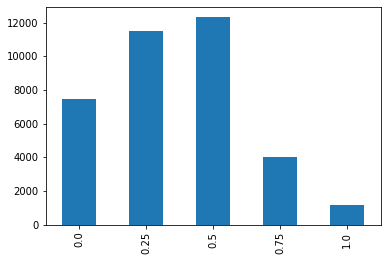

In [10]:
train['score'].value_counts(dropna=False).sort_index().plot.bar()

In [11]:
train.groupby(['anchor', 'context']).count()

id  target  score  title  section  class  subclass  \
anchor        context                                                       
abatement     A47      21      21     21     21       21     21         0   
              A61       3       3      3      3        3      3         0   
              A62       1       1      1      1        1      1         0   
              C01       1       1      1      1        1      1         0   
              F16       1       1      1      1        1      1         0   
...                    ..     ...    ...    ...      ...    ...       ...   
wiring trough F16      27      27     27     27       27     27         0   
              H02      18      18     18     18       18     18         0   
wood article  B05      28      28     28     28       28     28         0   
              B27       1       1      1      1        1      1         0   
              B44      27      27     27     27       27     27         0   

                       group  main_group  
anchor        context                     
abatement     A47          0           0  
              A61          0           0  
              A62          0           0  
              C01          0           0  
              F16          0           0  
...                      ...         ...  
wiring trough F16          0           0  
              H02          0           0  
wood article  B05          0           0  
              B27          0           0  
              B44          0           0  

[1699 rows x 9 columns]

# Data Preparation

In [12]:
# Preparing cpc text 
train['title'] = train.title.apply(lambda text: text.split(';'))
train['title'] = train.title.apply(lambda context: ' '.join(context))

In [13]:
train['corpus'] = train['anchor'] + ' ' + train['target']
train['corpus_w_context'] = train['corpus'] + ' ' +  train['context']
train['corpus_w_full_context'] = train['corpus'] + ' ' + train['title']

test['corpus'] = test['anchor'] + ' ' + test['target']
test['corpus_w_full_context'] = test['corpus'] + ' ' + test['title']

#### Identifing the features and the target.

In [14]:
y = train[['id','score']].copy()
X = train[['id','anchor','target','context', 'corpus', 'title', 'corpus_w_context', 'corpus_w_full_context']].copy()

## Training - Validation Split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y['score'])

In [16]:
training_target = X_train['target']
print(f'Length of training_target - list: {len(training_target)}')

training_content = X_train['corpus']
print(f'Length of training_content - list: {len(training_content)}')

training_content_w_context = X_train['corpus_w_context']
print(f'Length of training_content_w_context - list: {len(training_content_w_context)}')

training_content_full = X_train['corpus_w_full_context']
print(f'Length of training_content_full - list: {len(training_content_full)}')


validating_content = X_val['corpus']
print(f'Length of validating_content - list: {len(validating_content)}')

validating_content_w_context = X_val['corpus_w_context']
print(f'Length of validating_content_w_context - list: {len(validating_content_w_context)}')

validating_content_full = X_val['corpus_w_full_context']
print(f'Length of validating_content_full - list: {len(validating_content_full)}')


test_content = test['corpus']
print(f'Length of test_content - list: {len(test_content)}')

test_content_full = test['corpus_w_full_context']
print(f'Length of test_content_full - list: {len(test_content_full)}')

training_labels = y_train['score']
validating_labels = y_val['score']

training_labels = np.asarray(training_labels)
validating_labels = np.asarray(validating_labels)

Length of training_target - list: 25531
Length of training_content - list: 25531
Length of training_content_w_context - list: 25531
Length of training_content_full - list: 25531
Length of validating_content - list: 10942
Length of validating_content_w_context - list: 10942
Length of validating_content_full - list: 10942
Length of test_content - list: 36
Length of test_content_full - list: 36


#### Label Encoding

In [17]:
encoder = LabelEncoder()
encoder.fit(y_train['score'])

training_labels = encoder.transform(training_labels)
validating_labels = encoder.transform(validating_labels)

training_labels = training_labels.reshape(-1, 1)
validating_labels = validating_labels.reshape(-1, 1)

## Data Cleaning

### Tokenization, Encoding and Padding

In [18]:
def extract_words(document, alpha=True):
    '''Extracing words from a sentence or full text.

    Parameters
    ----------
    document: str
        Text that needs to be tokenized by nltk word_tokenize.
    alpha: bool
        Keep only letters or not. 
    
    Returns
    -------
    set
        A set of words from the given text.
    '''
    if alpha == True:
        return set(
            word.lower() for word in nltk.word_tokenize(document)
            if any(c.isalpha() for c in word)
        )
    else:
        return set(
            word.lower() for word in nltk.word_tokenize(document)
        )


In [19]:
def process_docs(docs):
    content = []
    for doc in docs:
        content.append(extract_words(doc))
    return content

def max_length(lines):
    return max([len(s.split()) for s in lines])

In [20]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_text(tokenizer, lines, length):
    sequences = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(sequences, maxlen=length)
    return padded


In [21]:
tokenizer = create_tokenizer(training_content_full)

In [22]:
vocab_size = len(tokenizer.word_index) + 1
max_line_length = max_length(training_content_full)
word_count = tokenizer.word_counts
word_index = tokenizer.word_index
oov_tok = "<OOV>"


In [23]:
training_content_enc = encode_text(tokenizer, training_content_full, max_line_length)
print(f'Shape training set (encoded): {training_content_enc.shape}')

validating_content_enc = encode_text(tokenizer, validating_content_full, max_line_length)
print(f'Shape validating set (encoded): {validating_content_enc.shape}')

print(f'Vocabulary size: {vocab_size}')
print(f'Max line lenght: {max_line_length}')

Shape training set (encoded): (25531, 51)
Shape validating set (encoded): (10942, 51)
Vocabulary size: 7750
Max line lenght: 51


# Helpers for Deep Neural Network Training

#### Params for the Glove based model

In [24]:
# Main params for the model
embedding_dim = 300 # according to the pretrained network
hits = 0
misses = 0
lr = 0.0000008
batch_size = 512
num_epochs = 50

#### Params for Deberta/Roberta based model

In [25]:
lr_deberta = 0.000000006 # 0.00002  # mal mit 0.000006 <-
num_epochs_deberta = 10 #3 #8 #5
batch_size_deberta = 16

In [26]:
from keras.callbacks import ReduceLROnPlateau

# Tensorboard logging structure function
root_logdir = "../../tensorboard-logs"

def get_run_logdir(root_logdir, project):
    '''
    Returns logdir to the Tensorboard log for a specific project.

            Parameters:
                    root_logdir (str) : basic logdir from Tensorboard
                    project (str): projectname that will be logged in TB

            Returns:
                    os.path (str): Path to the final logdir
    '''
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    project_logdir = os.path.join(root_logdir,project)
    return os.path.join(project_logdir, run_id)


def lr_scheduler(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  decay = 0.01 #1
  init_lr = lr_deberta 
  learning_rate = init_lr * (1 / (1 + decay * epoch))

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir(root_logdir,"nlp_phrase2phrase"), histogram_freq=1)
tensorboard_callback_deberta = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir(root_logdir,"nlp_phrase2phrase_deberta"), histogram_freq=1)
lr_callback_deberta = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

checkpoint_cb_deberta = keras.callbacks.ModelCheckpoint("trained_model_cp.h5", save_best_only=True, save_weights_only=True, save_freq='epoch', monitor='val_loss')
earlystopping_deberta = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

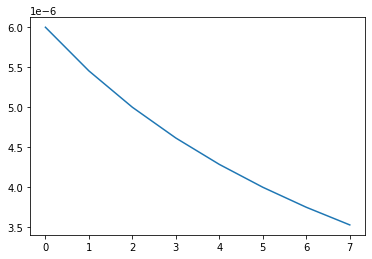

In [27]:
plt.plot([lr_scheduler(e) for e in range(8)])

# Model Development Based on Glove

## Pre-Trained Embeddings Load

In [28]:
embeddings_index = {}
with open(path_to_glove_file ,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Preparing a corresponding embedding matrix for the Embedding layer in Keras.

According to the choosen pre-trained embedding matrix we need to set the embedding dimension on 100.

In [29]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"Converted {hits} words ({misses} misses)")

Converted 7245 words (504 misses)


## Model Building
### The new Embedding Layer
Now loading the pre-trained word embedding matrix into the embedding layer. According to the pre-trained embedding load the trainable param needst to be set on "False".

In [30]:
#model = tf.keras.models.Sequential(
#    [
#    keras.layers.Embedding(    
#        vocab_size,
#        embedding_dim,
#        input_shape = [None],
#        input_length=max_line_length,
#        mask_zero=True,
#        weights=[embedding_matrix],
#        trainable = False),
#    keras.layers.SpatialDropout1D(0.3),
#    keras.layers.LSTM(300, return_sequences=True),
#    keras.layers.LSTM(300),
#    keras.layers.BatchNormalization(),
#    keras.layers.Activation('relu'),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(5, activation='softmax' )
#    ]
#)
#

In [31]:
#model.compile(loss='sparse_categorical_crossentropy',
#                #optimizer=keras.optimizers.Nadam(learning_rate=lr, beta_1=mmt),
#                optimizer=keras.optimizers.Adam(),
#                metrics=['accuracy']
#                )

In [32]:
#model.summary()

In [33]:
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='multichannel.png')

In [34]:
#history = model.fit(
#    np.asarray(training_content_enc),
#    np.asarray(training_labels),
#    batch_size=batch_size,      # small batch size are better but costs a lot of time
#    epochs=num_epochs,
#    validation_data=(
#        np.asarray(validating_content_enc),
#        np.asarray(validating_labels)),
#    verbose=1,
#    callbacks=[tensorboard_callback])

In [35]:
#model.save("LSTM_model_label_encoding_4.h5")

# Second Model Development based on Deberta 🤗

In [36]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

In [37]:
tokenizer_bert = AutoTokenizer.from_pretrained(ROBERTA_BASE)

In [38]:
model_deberta = TFAutoModelForSequenceClassification.from_pretrained(ROBERTA_BASE, trainable=True, return_dict=True, num_labels=5, output_hidden_states=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Trying around Huggingfaces Model and Tokenizer Structure
The following small try and errors for getting familiar with this framework is based on this huggingface documentation: https://huggingface.co/docs/transformers/glossary#:~:text=token%3A%20a%20part%20of%20a,based%20deep%20learning%20model%20architecture.

And this might be interesting for the Tokenizer topic as well: https://huggingface.co/docs/transformers/preprocessing


### Experiments with Deberta Tokenizer (🤗)
Converting a test sentence with doberta tokenizer

In [39]:
test_text_tok = tokenizer_bert('This is a Test')

Printing the results

In [40]:
test_text_tok

{'input_ids': [0, 713, 16, 10, 4500, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}

Printing the encoded results of the test sentence

In [41]:
test_text_tok["input_ids"]

[0, 713, 16, 10, 4500, 2]

Decoding the encoded test sentence back to its original form

In [42]:
tokenizer_bert.decode(test_text_tok["input_ids"])

'<s>This is a Test</s>'

#### Attention Mask

In [43]:
sentence_a = "This is a test"
sentence_b = "This is a test as well but its longer, much longer, longer than any other test could be"

Encoding both sentences and retrieving the ids only

In [44]:
encoded_sen_a = tokenizer_bert(sentence_a)["input_ids"]
encoded_sen_b = tokenizer_bert(sentence_b)["input_ids"]

print(f'sentence a encoded: {encoded_sen_a}')
print(f'sentence b encoded: {encoded_sen_b}')

sentence a encoded: [0, 713, 16, 10, 1296, 2]
sentence b encoded: [0, 713, 16, 10, 1296, 25, 157, 53, 63, 1181, 6, 203, 1181, 6, 1181, 87, 143, 97, 1296, 115, 28, 2]


Once again tokenizing the sentences but with padding activated

In [45]:
padded_sentences = tokenizer_bert([sentence_a, sentence_b], padding=True)

print(f'Sentences encoded: {padded_sentences["input_ids"]}')
print(f'Sentences att.msk: {padded_sentences["attention_mask"]}')

Sentences encoded: [[0, 713, 16, 10, 1296, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 713, 16, 10, 1296, 25, 157, 53, 63, 1181, 6, 203, 1181, 6, 1181, 87, 143, 97, 1296, 115, 28, 2]]
Sentences att.msk: [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


### Processing the Data for Deberta Model

In [46]:
MAX_LINE_LENGTH_BERT = len(tokenizer_bert(X_train['corpus_w_full_context'].tolist(), padding=True, truncation=True, return_tensors="tf")[1])
print(f"Maximum sentence length is: {MAX_LINE_LENGTH_BERT}")

Maximum sentence length is: 127


In [47]:
def preprocess_function(examples):
    return tokenizer_bert(examples['corpus_w_full_context'].tolist(), padding='max_length', truncation=True, return_tensors="tf", max_length=MAX_LINE_LENGTH_BERT)

In [48]:
#X_train.map(preprocess_function, batched=True)
train_encoded = preprocess_function(X_train)
val_encoded = preprocess_function(X_val)

print(f'Length of the train-sentences [padded]: {train_encoded["input_ids"].shape[1]}')
print(f'Length of the val-sentences [padded]: {val_encoded["input_ids"].shape[1]}')

Length of the train-sentences [padded]: 127
Length of the val-sentences [padded]: 127


### Model Build


In [49]:
print(f'Number of labels, that came from deberta model: {model_deberta.num_labels}')

Number of labels, that came from deberta model: 5


In [50]:
_input_ids_ = tf.keras.Input(shape = (MAX_LINE_LENGTH_BERT, ), dtype = tf.int32)
_attention_mask_ = tf.keras.Input(shape = (MAX_LINE_LENGTH_BERT, ), dtype = tf.int32)

x = model_deberta(
                input_ids = _input_ids_,
                attention_mask = _attention_mask_,
                output_hidden_states=True
                ),
#print(x[0])
#print('-----------------------------------')
#print(x[0].hidden_states)
#print('-----------------------------------')
#print(x[0].hidden_states[-1])
x = tf.keras.layers.GlobalAveragePooling1D()(x[0].hidden_states[-1])
#x = tf.keras.layers.SpatialDropout1D(0.3)(x[0].hidden_states[-1]),
#x = tf.keras.layers.Dropout(0.3)(x)
#x = tf.keras.layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model2 = tf.keras.Model(inputs = [_input_ids_, _attention_mask_], 
                        outputs = output
                        )

In [51]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [52]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 127)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 127)]        0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124649477  ['input_1[0][0]',                
 fication (TFRobertaForSequence  rOutput(loss=None,               'input_2[0][0]']                
 Classification)                logits=(None, 5),                                                 
                                 hidden_states=((No                                           

### Model Fit

In [53]:
history_model2 = model2.fit(x=(np.asarray(train_encoded['input_ids']),
                                np.asarray(train_encoded['attention_mask'])
                                ),
                                y=np.asarray(training_labels),
                                validation_data=((np.asarray(val_encoded['input_ids']),
                                                  np.asarray(val_encoded['attention_mask'])),
                                                np.asarray(validating_labels)
                                                ),
                                epochs=num_epochs_deberta,
                                batch_size=batch_size_deberta,
                                callbacks =[tensorboard_callback_deberta,
                                            lr_callback_deberta,
                                            checkpoint_cb_deberta,
                                            earlystopping_deberta]) #lr_callback rlrop

Epoch 1/10
1596/1596 [==============================] - 461s 276ms/step - loss: 1.1213 - accuracy: 0.5274 - val_loss: 0.9590 - val_accuracy: 0.6162 - lr: 6.0000e-06
Epoch 2/10
1596/1596 [==============================] - 441s 276ms/step - loss: 0.9087 - accuracy: 0.6304 - val_loss: 0.9074 - val_accuracy: 0.6396 - lr: 5.4545e-06
Epoch 3/10
1596/1596 [==============================] - 440s 276ms/step - loss: 0.8149 - accuracy: 0.6683 - val_loss: 0.8631 - val_accuracy: 0.6631 - lr: 5.0000e-06
Epoch 4/10
1411/1596 [=========================>....] - ETA: 44s - loss: 0.7359 - accuracy: 0.7005

KeyboardInterrupt: 

In [ ]:
model2.save("deberta_trained_10_epochs_decay_0_02_lr_1.h5")

In [44]:
#from keras.models import load_model
# Or load the saved model from the callback : deberta_trained_model.h5
# model2.load_weights('deberta_trained_model.h5') #deberta_trained_10_epochs_decay_lr_1 # deberta_trained_3_epochs_decay_lr

#### Accuracy Curve

Text(0.5, 1.0, 'lrate=8e-07')

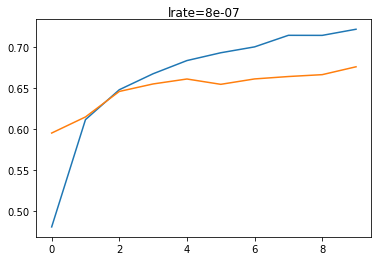

In [188]:
plt.plot(history_model2.history['accuracy'], label='train')
plt.plot(history_model2.history['val_accuracy'], label='test')
plt.title('lrate='+str(lr), pad=-50)

#### Loss Curve

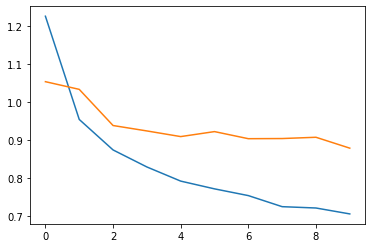

In [180]:
plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])

# Evaluation

## Test with all Validation Data

In [178]:
evaluation = model2.evaluate((np.asarray(val_encoded['input_ids']),
                              np.asarray(val_encoded['attention_mask']),
                             ),
                             validating_labels, verbose=0)

print(f'Models validation loss: {evaluation[0]} - Models validation accuracy: {evaluation[1]}')

Models validation loss: 0.8778802156448364 - Models validation accuracy: 0.6757448315620422


# Submission File

## Training on all Data

## Prediction of Test File Values

In [181]:
#competition_file = pd.DataFrame(columns=['score'])
competition_file = pd.read_csv(PHRASES_PATH + "/sample_submission.csv")

In [105]:
test_encoded = preprocess_function(test)

In [183]:
test_prediction = model2.predict((np.asarray(test_encoded['input_ids']),
                                  np.asarray(test_encoded['attention_mask']) 
                                  ))

In [184]:
competition_file['score'] = encoder.inverse_transform(np.argmax(test_prediction, axis=1))

<AxesSubplot:>

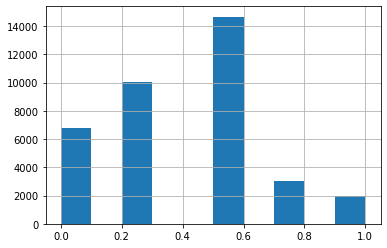

In [185]:
competition_file['score'].hist()

In [186]:
competition_file.to_csv('submission.csv', index=False)